# データ初期化

In [8]:
import numpy as np
from keras.datasets import mnist

import torch

import math

In [70]:
(x_train, t_train), (x_test, t_test) = mnist.load_data()
x_train = x_train.reshape(60000, 1, 28, 28)
x_test = x_test.reshape(10000, 1, 28, 28)

x_train = (x_train / 255)
x_test = (x_test / 255)

x_train, t_train, x_test, t_test = map(
    torch.tensor,
    (x_train, t_train, x_test, t_test)
)

x_train = x_train.data.type(torch.float32)
x_test = x_test.data.type(torch.float32)
t_train = t_train.data.type(torch.float32)
t_test = t_test.data.type(torch.float32)

# y_train = torch.nn.functional.one_hot(y_train.to(torch.int64), num_classes=10)
# y_test = torch.nn.functional.one_hot(y_test.to(torch.int64), num_classes=10)


torch.Size([60000, 1, 28, 28])


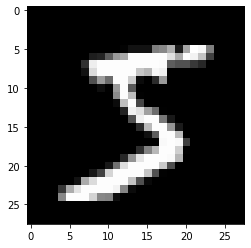

In [71]:
from matplotlib import pyplot

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

# スクラッチ

In [72]:
# w1 = torch.rand(784, 50, requires_grad=True, dtype=torch.float)
# w2 = torch.rand(50, 50, requires_grad=True, dtype=torch.float)
# w3 = torch.rand(50, 25, requires_grad=True, dtype=torch.float)
# w4 = torch.rand(25, 10, requires_grad=True, dtype=torch.float)

# for t in range(100):
#     h1 = x_train @ w1
#     z1 = torch.relu(h1)
#     h2 = z1 @ w2
#     z2 = torch.relu(h2)
#     h3 = z2 @ w3
#     z3 = torch.relu(h3)
#     h4 = z3 @ w4
#     y_pred = torch.sigmoid(torch.div(h4, torch.max(h4)))
    
#     loss = (y_pred - y_train).pow(2).sum()
    
#     if (t % 10 == 9):
#         print(t, loss.item() // 1)
# #         print(y_pred[0], y_train[0], h4[0], h3[0], h2[0], h1[0])
    
#     loss.backward()
    
#     with torch.no_grad():
#         w1 -= 0.01 * w1.grad
#         w2 -= 0.01 * w2.grad
#         w3 -= 0.01 * w3.grad
#         w4 -= 0.01 * w4.grad
        
#         w1.grad.zero_()
#         w2.grad.zero_()
#         w3.grad.zero_()
#         w4.grad.zero_()


In [73]:
from torch.utils.data import TensorDataset, DataLoader

ds_train = TensorDataset(x_train, t_train)
ds_test = TensorDataset(x_test, t_test)

loader_train = DataLoader(ds_train, batch_size=128, shuffle=True)
loader_test = DataLoader(ds_train, batch_size=128, shuffle=False)

# nn

In [120]:
channel = 1
image = 28
layer_num = 32
kernel_size = 3
pool_size = 4
output = 10

model = torch.nn.Sequential(
  torch.nn.Conv2d(channel, layer_num, kernel_size),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d(pool_size, pool_size),
  torch.nn.Flatten(),
  torch.nn.Linear(((image - kernel_size + 1) // pool_size) ** 2 * layer_num, output),
)

from torchsummary import summary
summary(model, input_size=(channel,image,image))


optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(10):
  loss_train = []
  loss_test = []
  train_num = 0
  test_num = 0
  train_true_num = 0
  test_true_num = 0
  
  model.train()
  for x, t in loader_train:
    optimizer.zero_grad()
    
    y = model(x)
    
    loss = criterion(y, t.long())
    loss.backward()

    optimizer.step()
    
    loss_train.append(loss.tolist())
    train_num += t.shape[0]
    train_true_num += (y.argmax(1) == t).sum().item()
  
  model.eval()
  for x, t in loader_test:
    y = model(x)
    loss = criterion(y, t.long())
    loss_test.append(loss.tolist())
    test_num += t.shape[0]
    test_true_num += (y.argmax(1) == t).sum().item()
        
  print("エポック：{}, 訓練正解率:{:.3f}, テスト正解率：{:.3f}".format(epoch + 1, train_true_num/train_num, test_true_num/test_num))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
         MaxPool2d-3             [-1, 32, 6, 6]               0
           Flatten-4                 [-1, 1152]               0
            Linear-5                   [-1, 10]          11,530
Total params: 11,850
Trainable params: 11,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 0.05
Estimated Total Size (MB): 0.40
----------------------------------------------------------------
エポック：1, 訓練正解率:0.883, テスト正解率：0.951
エポック：2, 訓練正解率:0.961, テスト正解率：0.967
エポック：3, 訓練正解率:0.971, テスト正解率：0.970
エポック：4, 訓練正解率:0.975, テスト正解率：0.977
エポック：5, 訓練正解率:0.977, テスト正解率：0.978
エポック：6, 訓練正解率:0.979, テスト正解率：0.982
エポック：7, 訓練正解率:0.981, テスト正解率：0.98